## Google Analytics Customer Revenue Prediction

### Importing packages

In [2]:
# File system manangement
import os
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
# Numpy and pandas for data manipulation
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 300)
# Importing random for random selections
import random
# Json for importing JSON columns
import json as json
# Pandas io json normalizing
from pandas.io.json import json_normalize
# Scipy stats for statistical analysis
import scipy.stats as stats
# sklearn preprocessing for dealing with categorical features
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
# to use for woe binning for features with a large number of categories
import scorecardpy as sc
# Light gradient boost classifier
from lightgbm import LGBMRegressor
# Sklearn Inputing data spliting method
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
# Sklearn importing auc as measurement metric
from sklearn.metrics import mean_squared_error
# Gc memory managment
import gc
# Matplotlib pyplot for plotting
import matplotlib.pyplot as plt
# Seabourne for visualization
import seaborn as sns
sns.set_style('white')

### Importing data

In [ ]:
# # Setting up package to import data converting JSON columns into individual features
# # https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields
# JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
# def load_df(csv_path):
#     df = pd.read_csv(csv_path, converters={column: json.loads for column in JSON_COLUMNS}\
#                      , dtype={'fullVisitorId': 'str', 'visitStartTime': 'str', 'date': 'str'})
#     for column in JSON_COLUMNS:
#         column_as_df = json_normalize(df[column])
#         column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
#         df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
#     return df

In [ ]:
# # Seeting the input and output directory
# os.chdir('C:/Users/Jake Cherrie/Documents/Projects/Gstore Revenue Prediction')
# # Viewing the contained datasets
# os.listdir('C:/Users/Jake Cherrie/Data Sets/Gstore Revenue Prediction')

In [ ]:
# # Importing the training data
# trn_df = load_df('C:/Users/Jake Cherrie/Data Sets/Gstore Revenue Prediction/train.csv')
# trn_df['totals.transactionRevenue'].fillna(0, inplace = True)

In [ ]:
# # Droping features with no information
# drp_cols = [col for col in trn_df.columns if trn_df[col].nunique() == 1 & trn_df[col].notnull().values.all()]
# trn_df = trn_df.drop(columns=drp_cols)
# # Dropping duplicate feature visitStartTime is the same as visitId
# trn_df = trn_df.drop(columns='visitId')
# # Dropping capaign code as there is ony 1 non-null entry
# trn_df = trn_df.drop(columns='trafficSource.campaignCode')
# # Noticed that for the training set channelGrouping contains all the information in trafficSource.medium so droping trafficSource.medium
# trn_df = trn_df.drop(columns='trafficSource.medium')

In [ ]:
# # Saving memory by shortning ints and floats
# def size_reduction(df):
#     int_col     = df.select_dtypes(include=[np.int64]).columns
#     flt_col     = df.select_dtypes(include=[np.float64]).columns 
#     df[int_col] = df[int_col].astype(np.int32)
#     df[flt_col] = df[flt_col].astype(np.float32)  
# size_reduction(trn_df)
# gc.collect()

In [ ]:
# trn_df.describe(include='all')

In [ ]:
## Importing the testing data
# tst_df = load_df('C:/Users/Jake Cherrie/Data Sets/Gstore Revenue Prediction/test.csv')

In [ ]:
## Quick view of training data
# tst_df.info()

In [ ]:
# # Droping features with no information
# drp_cols = [col for col in tst_df.columns if tst_df[col].nunique() == 1 & tst_df[col].notnull().values.all()]
# tst_df = tst_df.drop(columns=drp_cols)
# # Dropping duplicate feature visitStartTime is the same as visitId
# tst_df = tst_df.drop(columns='visitId')
# tst_df = tst_df.drop(columns='trafficSource.medium')

# size_reduction(tst_df)
# gc.collect()

In [ ]:
# tst_df.describe(include='all')

### Saving Data for Quick Loads and Debugging

In [ ]:
# trn_df.to_csv('C:/Users/Jake Cherrie/Data Sets/Gstore Revenue Prediction/trn.csv', index=False)
# tst_df.to_csv('C:/Users/Jake Cherrie/Data Sets/Gstore Revenue Prediction/tst.csv', index=False)

In [3]:
trn = pd.read_csv('C:/Users/Jake Cherrie/Data Sets/Gstore Revenue Prediction/trn.csv'\
           , dtype={'fullVisitorId': 'str', 'visitStartTime': 'str', 'date': 'str'}, nrows=None)
tst = pd.read_csv('C:/Users/Jake Cherrie/Data Sets/Gstore Revenue Prediction/tst.csv'\
           , dtype={'fullVisitorId': 'str', 'visitStartTime': 'str', 'date': 'str'}, nrows=None)
gc.collect()

7

In [4]:
# Setting the index as fullVisitorId
trn.set_index('fullVisitorId', inplace=True)
tst.set_index('fullVisitorId', inplace=True)

In [5]:
trn_df = trn.copy()
tst_df = tst.copy()

In [105]:
# Setting up debugging datasets
random.seed(42)
dbg_trn = random.sample(list(pd.Series(trn.index.values).unique()),300000)
dbg_tst = random.sample(list(pd.Series(tst.index.values).unique()),200000)
trn_df = trn.loc[dbg_trn]
tst_df = tst.loc[dbg_tst]

### Grouping Features

In [106]:
# Applying the simple bins to the data frame
def deviceBrowser(x):
    if x in ['Chrome', 'Safari', 'Firefox', 'Safari (in-app)', 'Amazon Silk', 'Opera', 'Android Webview']:
        return x
    elif x in ['Internet Explorer', 'Edge']:
        return 'Microsoft Browser'
    else:
        return 'Other'
trn_df['device.browser'] = trn_df['device.browser'].map(lambda x:deviceBrowser(x))
tst_df['device.browser'] = tst_df['device.browser'].map(lambda x:deviceBrowser(x))

In [107]:
# Applying the simple bins to the data frame
def deviceOperatingSystem(x):
    if x in ['Android', 'Chrome OS', 'Linux', 'Macintosh', 'Windows', 'iOS', '(not set)', 'Samsung']:
        return x
    elif x in ['BlackBerry', 'Windows Phone']:
        return 'Other Phone'
    elif x in ['Xbox', 'Playstation Vita', 'Nintendo WiiU', 'Nintendo 3DS']:
        return 'Gaming'
    else:
        return 'Other'
trn_df['device.operatingSystem'] = trn_df['device.operatingSystem'].map(lambda x:deviceOperatingSystem(x))
tst_df['device.operatingSystem'] = tst_df['device.operatingSystem'].map(lambda x:deviceOperatingSystem(x))

In [108]:
# Applying the simple bins to the data frame
def trafficSourceAdContent(x):
    if pd.isnull(x):
        return 'NA'
    elif 'Google' in x:
        return 'google'
    elif 'Ad' in x.lower():
        return 'Ad'
    elif 'discount' in x:
        return 'Discount'
    else:
        return 'Other'
trn_df['trafficSource.adContent'] = trn_df['trafficSource.adContent'].map(lambda x:trafficSourceAdContent(x))
tst_df['trafficSource.adContent'] = tst_df['trafficSource.adContent'].map(lambda x:trafficSourceAdContent(x))

In [109]:
# Applying groups (makes the cv worse)
def trafficSourceCampaign(x):
    if '(not set)' in x:
        return '(not set)'
    elif 'AW' in x:
        return 'AW'
    elif 'Data Share Promo' in x:
        return 'Data Share Promo'
    elif ('google+redesign' in x) or ('google + redesign' in x):
        return 'redesign'
    else:
        return 'Other'
trn_df['trafficSource.campaign'] = trn_df['trafficSource.campaign'].map(lambda x:trafficSourceCampaign(x))
tst_df['trafficSource.campaign'] = tst_df['trafficSource.campaign'].map(lambda x:trafficSourceCampaign(x))

In [110]:
# Applying bins (makes it worse then none...)
def trafficSourceKeyword(x):
    if pd.isnull(x):
        return 'NA'
    elif '6qehscssdk0z36ri' in x:
        return '???'
    elif '(not provided)' in x:
        return '(not provided)'
    elif (('google' in x) and ('merchandise' in x)) or (('google' in x) and ('merch' in x))\
      or (('google' in x) and ('stickers' in x))    or (('google' in x) and ('shirt' in x))\
      or (('google' in x) and ('swag' in x))        or (('google' in x) and ('gear' in x))\
      or (('google' in x) and ('accessories' in x)):
        return 'Google Merch'
    else:
        return 'Other'
trn_df['trafficSource.keyword'] = trn_df['trafficSource.keyword'].map(lambda x:trafficSourceKeyword(str(x).lower()))
tst_df['trafficSource.keyword'] = tst_df['trafficSource.keyword'].map(lambda x:trafficSourceKeyword(str(x).lower()))

In [111]:
# Applying bins (makes it worse then none...)
def trafficSourceSource(x):
    if x in ['google', 'mall.googleplex.com', '(direct)', 'dfa', 'dealspotr.com']:
        return x
    elif x in ['youtube.com', 'Partners']:
        return 'Partners'
    elif 'google' in str(x).lower():
        return 'Other Google'
    else:
        return 'Other'
trn_df['trafficSource.source'] = trn_df['trafficSource.source'].map(lambda x:trafficSourceSource(x))
tst_df['trafficSource.source'] = tst_df['trafficSource.source'].map(lambda x:trafficSourceSource(x))

### Creating New Combination Features

In [112]:
# Setting up a has revenue flag
trn_df['hasRevenue'] = (trn_df['totals.transactionRevenue'] > 0).astype(int)
trn_df['logRevenue'] = np.log1p(trn_df['totals.transactionRevenue'])

In [56]:
tst_df['trafficSource.keyword'].unique()

array(['Other', '(not provided)', '???', 'Google Merch'], dtype=object)

In [57]:
trn_df.describe(include='all')

,channelGrouping,date,sessionId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.referralPath,trafficSource.source,hasRevenue,logRevenue
count,379215,379215,379215,379215.000000,379215,379215,379215,379215,379215,379215,379215,379215,379215,379215,379215,379215,188681.0,379215.000000,295237.0,379175.000000,3.792150e+05,379215,8849,8889,8849,8849.000000,8849,379215,114929,379215,139123,379215,379215.000000,379215.000000
unique,8,366,378857,NaN,376278,9,3,2,11,639,6,214,94,17038,372,23,NaN,NaN,NaN,NaN,NaN,4,2,7410,1,NaN,2,4,1,4,972,8,NaN,NaN
top,Organic Search,20161128,7053760850731460997_1496300394,NaN,1495031359,Chrome,desktop,False,Windows,not available in demo dataset,Americas,United States,not available in demo dataset,(not set),not available in demo dataset,Northern America,NaN,NaN,NaN,NaN,NaN,NA,Google Search,CjwKEAiAj7TCBRCp2Z22ue-zrj4SJACG7SBEJui6ggr6oc...,False,NaN,Top,(not set),True,Other,/,google,NaN,NaN
freq,160025,2043,2,NaN,4,260207,279187,279200,147156,213250,188792,153253,213250,102409,213250,163969,NaN,NaN,NaN,NaN,NaN,374747,8843,24,8849,NaN,8651,363198,114929,217977,31579,167944,NaN,NaN
mean,NaN,NaN,NaN,2.234268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.605569,1.0,3.855929,1.782678e+06,NaN,NaN,NaN,NaN,1.006328,NaN,NaN,NaN,NaN,NaN,NaN,0.012879,0.229576
std,NaN,NaN,NaN,9.058815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,9.785912,0.0,7.162013,6.279935e+07,NaN,NaN,NaN,NaN,0.119166,NaN,NaN,NaN,NaN,NaN,NaN,0.112754,2.014528
min,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.000000,1.0,1.000000,0.000000e+00,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.000000,1.0,1.000000,0.000000e+00,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
50%,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.000000,1.0,2.000000,0.000000e+00,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
75%,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.000000,1.0,4.000000,0.000000e+00,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000


array(['(not provided)', '???', 'Google Merch', 'Other'], dtype=object)

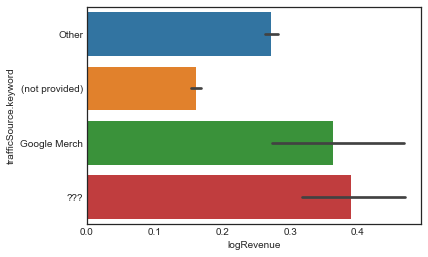

In [58]:
cols = trn_df[trn_df['totals.transactionRevenue'] > 0].groupby('trafficSource.keyword')['trafficSource.keyword'].unique().index.values
sns.barplot(y='trafficSource.keyword', x='logRevenue', data=trn_df[trn_df['trafficSource.keyword'].isin(cols)])
cols

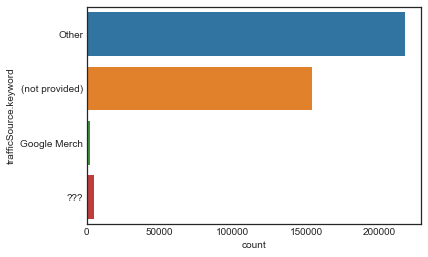

In [59]:
# Ploting count per group
sns.countplot(y='trafficSource.keyword', data=trn_df[trn_df['trafficSource.keyword'].isin(cols)])

### Creating Time Features

In [113]:
#Looking at first and last shows that it is clearly a time dependent problem
trn_df['visitStartTime'] = pd.to_datetime(trn_df['visitStartTime'],unit='s')
print(trn_df['visitStartTime'].describe())
tst_df['visitStartTime'] = pd.to_datetime(tst_df['visitStartTime'],unit='s')
print(tst_df['visitStartTime'].describe())

count                  379215
unique                 376278
top       2017-05-09 23:56:39
freq                        4
first     2016-08-01 07:00:12
last      2017-08-02 06:59:46
Name: visitStartTime, dtype: object
count                  261443
unique                 257990
top       2017-12-13 00:31:19
freq                       11
first     2017-08-02 07:00:03
last      2018-05-01 06:56:00
Name: visitStartTime, dtype: object


In [114]:
trn_df['weekday'] = trn_df['visitStartTime'].dt.weekday.astype(str)
tst_df['weekday'] = tst_df['visitStartTime'].dt.weekday.astype(str)

In [115]:
trn_df['time']  = trn_df['visitStartTime'].dt.hour.astype(str)
tst_df['time']  = tst_df['visitStartTime'].dt.hour.astype(str)

In [116]:
# Time since last and till next session
def sessions(df):
    df['timePrevSession'] = (
            df['visitStartTime'] - df.groupby('fullVisitorId')['visitStartTime'].shift(1)
        ).astype(np.int64) // 1e9 // 60 // 60
    df['timeNextSession'] = (
            df.groupby('fullVisitorId')['visitStartTime'].shift(-1) - df['visitStartTime']
        ).astype(np.int64) // 1e9 // 60 // 60
sessions(trn_df)
sessions(tst_df)

In [117]:
# Number of visits
trn_df['totalVisits'] = trn_df.groupby('fullVisitorId')['visitNumber'].max()
tst_df['totalVisits'] = tst_df.groupby('fullVisitorId')['visitNumber'].max()

In [ ]:
# Number of future visits
temp = trn_df.copy()

def numLastHours(df, periods = [12]):
#     print(periods, type(df), df)
    results = pd.DataFrame(index=pd.DataFrame(df).index, columns=periods)
    for period in periods: 
        for index, date in df['visitStartTime'].items():
            time_range = df['visitStartTime'].between(date - pd.to_timedelta(period, 'h'), date)
            results.loc[index, period] = time_range.sum() - 1
    return results.fillna(0).astype(int)

results = pd.concat(numLastHours(group[1]) for group in temp.groupby('fullVisitorId'))
results


In [ ]:
def hours(x,y):
    ((df['visitStartTime'] - df['visitStartTime']).astype(np.int64) // 1e9 // 60 // 60)
hours(x,y):

### Encoding Categorical Features

#### Weekday

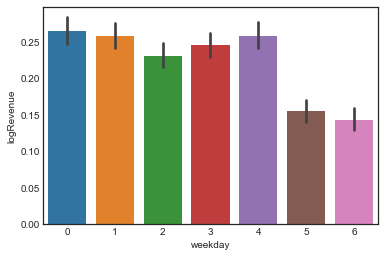

In [118]:
# Plotting the weekday relationship to the log1p revenue
sns.barplot('weekday', 'logRevenue', data = trn_df)

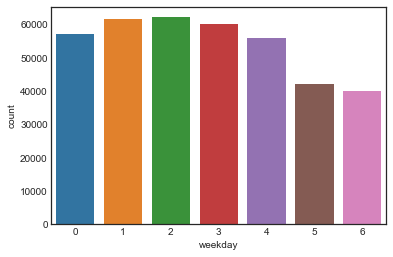

In [119]:
# Ploting count per group
sns.countplot('weekday', data=trn_df)

In [120]:
# Weight of Evidence (WOE) encoding
weekday = trn_df[['weekday','hasRevenue']]
#bins_weekday = sc.woebin(weekday, y='hasRevenue', stop_limit=0.02, max_num_bin=2, method='tree')
#Saving for quick load    
#np.save('C:/Users/Jake Cherrie/Data Sets/Gstore Revenue Prediction/Bins sets/bins_weekday.npy', bins_weekday) 
# Quick load of dataframe
bins_weekday = np.load('C:/Users/Jake Cherrie/Data Sets/Gstore Revenue Prediction/Bins sets/bins_weekday.npy').item()
bins_weekday

{'weekday':   variable                bin   count  count_distr    good   bad   badprob  \
 0  weekday              6%,%5   82830     0.218288   82132   698  0.008427   
 1  weekday  2%,%3%,%4%,%1%,%0  296623     0.781712  292568  4055  0.013671   
 
         woe    bin_iv  total_iv             breaks  is_special_values  
 0 -0.400514  0.028973  0.035382              6%,%5              False  
 1  0.088603  0.006410  0.035382  2%,%3%,%4%,%1%,%0              False  }

In [121]:
# Applying WOE encoding
#trn_df['weekday'] = sc.woebin_ply(trn_df, bins_weekday)['weekday_woe']
#tst_df['weekday'] = sc.woebin_ply(tst_df, bins_weekday)['weekday_woe']

### Creating and encoding feature and target datasets

In [122]:
#Dropping unused features
trn_set = trn_df.drop(columns=['visitStartTime', 'date', 'sessionId', 'trafficSource.adwordsClickInfo.gclId'])
tst_set = tst_df.drop(columns=['visitStartTime', 'date', 'sessionId', 'trafficSource.adwordsClickInfo.gclId'])

In [123]:
# Creating feature and target sets
trn_fts = trn_set[tst_set.columns]
trn_tgt = trn_set['logRevenue']
tst_fts = tst_set

In [124]:
trn_fts.shape, tst_fts.shape

((379215, 32), (261443, 32))

In [125]:
#Setting up categorical columns
cat_col = [col for col in trn_fts.columns if trn_fts[col].dtype == 'object']
# factorizing categorical columns
for col in cat_col:
    indexer = pd.factorize(trn_set[col])[1]
    trn_fts[col] = indexer.get_indexer(trn_fts[col])
    tst_fts[col] = indexer.get_indexer(tst_fts[col])
# Converting bool into int
trn_fts['device.isMobile'] = trn_fts['device.isMobile'].astype(int)
tst_fts['device.isMobile'] = tst_fts['device.isMobile'].astype(int)

### Visit ID Level Fit

In [127]:
# Initializing lgb paramaters
params={'num_leaves': 31,
        'max_depth': 16,
        'learning_rate': 0.03,
        'n_estimators': 1000,
        'metric':'rmse',
        'num_leaves': 31,
        'verbose': 1,
        "subsample": 0.9,
        "colsample_bytree": 0.9,
        "random_state":42,
        'min_child_samples': 20
       }

In [128]:
unq_vis = np.array(sorted(pd.Series(trn_df.index.values).unique()))
# Get folds
Kflds = KFold(n_splits=5, shuffle=True, random_state=42)
flds = []
for trn_, vld in Kflds.split(X=unq_vis, y=unq_vis):
    flds.append([unq_vis[trn_],unq_vis[vld]])

In [129]:
# Initializing Variables
trn_df['prd'] = 0
trn_prd =  trn_df['prd']
tst_prd = np.zeros(tst_fts.shape[0])
imp = pd.DataFrame()
wgt_sum = 0
MSE = 0

for n_fld ,(trn_idx, vld_idx) in enumerate(flds):
    #trn_idx = idx_tab.iloc[trn_num].index
    #vld_idx = idx_tab.iloc[vld_num].index
    trn_X, trn_y = trn_fts.loc[trn_idx], trn_tgt.loc[trn_idx]
    vld_X, vld_y = trn_fts.loc[vld_idx], trn_tgt.loc[vld_idx]
    
    lgb = LGBMRegressor(**params)
    
    # Fit the model
    lgb.fit(trn_X, trn_y)
    
    # applying the model to the validation data
    val_prd = lgb.predict(vld_X)
    val_prd[val_prd < 0] = 0
    # Calculating and outputting the RMSE
    fld_MSE = mean_squared_error(vld_y, val_prd)
    print('Fold %2d RMSE : %.6f' % (n_fld + 1, np.sqrt(fld_MSE)))
    
    # Summing mean squared errors
    MSE += fld_MSE/5
    wgt_sum += 1/np.sqrt(fld_MSE)
    
    # Applying predictions to the train set weighted by the MSE
    prd = lgb.predict(vld_X)
    prd[prd < 0] = 0
    trn_prd.loc[vld_idx] = prd
    
    # Applying predictions to the test set weighted by the MSE
    prd = lgb.predict(tst_fts)
    prd[prd < 0] = 0
    tst_prd += prd/np.sqrt(fld_MSE)
    
    # Calculating the fold importance
    imp_df = pd.DataFrame()
    imp_df['fts'] = trn_X.columns
    imp_df['imp'] = lgb.booster_.feature_importance(importance_type='gain')
    
    # Summing the fold importances
    imp_df['fld'] = n_fld+1
    imp = pd.concat([imp, imp_df], axis=0, sort=False)

np.sqrt(MSE)
# full = 1.6336474922884041
# 1.6387851689243524
# 1.6377402085589046

Fold  1 RMSE : 1.688263
Fold  2 RMSE : 1.662246
Fold  3 RMSE : 1.598508
Fold  4 RMSE : 1.632188
Fold  5 RMSE : 1.605741


1.6377402085589046

In [103]:
# Scaling and assigning the predictions
trn_fts['prd'] = np.expm1(trn_prd)
trn_fts['log_prd'] = trn_prd
tst_fts['prd'] = np.expm1(tst_prd/wgt_sum)
tst_fts['log_prd'] = tst_prd/wgt_sum

Text(0.5,1,'Features (avg over folds)')

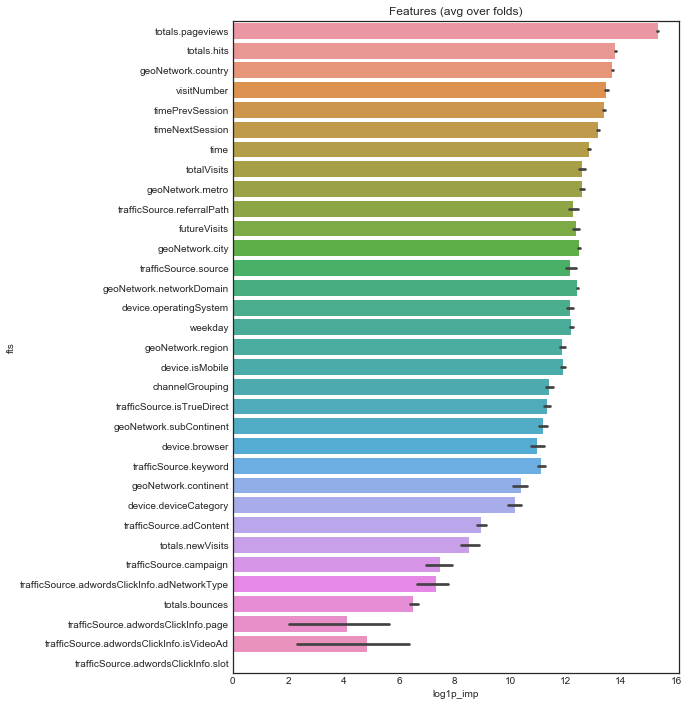

In [104]:
# Ploting stage 1 feature importances
cols = imp[["fts", "imp"]].groupby("fts").mean().sort_values(by="imp", ascending=False)[:60].index
imp['log1p_imp'] = np.log1p(imp['imp'])
best_features = imp.loc[imp.fts.isin(cols)]
plt.figure(figsize=(8, 12))
sns.barplot(x="log1p_imp", y="fts", data=best_features.sort_values(by="imp", ascending=False))
plt.title('Features (avg over folds)')

In [74]:
# Create a list of predictions for each Visitor
def prediction_list(df):
    prd_lst = df.groupby('fullVisitorId')['log_prd']\
                .apply(lambda df: list(df))\
                .apply(lambda x: {'pred_'+str(i): pred for i, pred in enumerate(x[:10])})
    return pd.DataFrame(index=pd.Series(df.index.values).unique(),data=list(prd_lst.values))

In [75]:
# Features: Perform aggregations
aggregations = {
    'channelGrouping': ['median'],
    'visitNumber': ['max', 'sum'],
    'device.browser': ['median'],
    'device.deviceCategory': ['median'], 
    'device.isMobile': ['max', 'sum', 'min'], 
    'device.operatingSystem': ['median'],
    'geoNetwork.city': ['median'], 
    'geoNetwork.continent': ['median'], 
    'geoNetwork.country': ['median'],
    'geoNetwork.metro': ['median'], 
    'geoNetwork.networkDomain': ['median'], 
    'geoNetwork.region': ['median'],
    'geoNetwork.subContinent': ['median'], 
    'totals.bounces': ['max','sum'], 
    'totals.hits': ['max'],
    'totals.newVisits': ['max'], 
    'totals.pageviews': ['max'], 
    'trafficSource.adContent': ['median'],
    'trafficSource.adwordsClickInfo.adNetworkType': ['median'],
    #'trafficSource.adwordsClickInfo.gclId': ['median'],
    'trafficSource.adwordsClickInfo.isVideoAd': ['median'],
    'trafficSource.adwordsClickInfo.page': ['median'],
    'trafficSource.adwordsClickInfo.slot': ['median'], 
    'trafficSource.campaign': ['median'],
    'trafficSource.isTrueDirect': ['median'], 
    'trafficSource.keyword': ['median'],
    'trafficSource.referralPath': ['median'], 
    'trafficSource.source': ['median'],
    'log_prd': ['sum','max'],
    'prd': ['sum','max'],
    'prev_session': ['mean', 'sum'],
    'next_session': ['mean', 'sum']
}

In [ ]:
trn_agg = trn_fts.groupby('fullVisitorId').agg(aggregations)
trn_agg.columns = pd.Index([e[0] + "." + e[1].upper() for e in trn_agg.columns.tolist()])
tst_agg = tst_fts.groupby('fullVisitorId').agg(aggregations)
tst_agg.columns = pd.Index([e[0] + "." + e[1].upper() for e in tst_agg.columns.tolist()])

In [ ]:
# Adding visit prediction
#trn_agg = pd.concat([trn_agg, prediction_list(trn_fts)], axis=1)
#size_reduction(trn_agg)
#tst_agg = pd.concat([tst_agg, prediction_list(tst_fts)], axis=1)
#size_reduction(tst_agg)
#trn_agg = trn_agg[tst_agg.columns]
#gc.collect()

In [ ]:
trn_agg['prd.SUM'] = np.log1p(trn_agg['prd.SUM'])
tst_agg['prd.SUM'] = np.log1p(tst_agg['prd.SUM'])

In [ ]:
tgt_agg = np.log1p(trn_df.groupby('fullVisitorId').sum()['totals.transactionRevenue'])

In [ ]:
trn_agg.shape, tst_agg.shape

In [ ]:
# Initializing stage 2 paramaters
params={'num_leaves': 31,
        'max_depth': 15,
        'learning_rate': 0.03,
        'n_estimators': 1200,
        'num_leaves': 31,
        'verbose': 100,
        "subsample": 0.9,
        "colsample_bytree": 0.9,
        "random_state":42,
        'lambda_l2': 0.02085548700474218,
        'lambda_l1': 0.004107624022751344,
        'bagging_fraction': 0.7934712636944741,
        'feature_fraction': 0.686612409641711
       }

In [ ]:
# Initializing Variables
sub_prd = np.zeros(tst_agg.shape[0])
imp = pd.DataFrame()
wgt_sum  = 0
MSE = 0

for n_fld, (trn_idx, vld_idx) in enumerate(flds):
    #trn_idx = idx_tab.iloc[trn_num].index
    #vld_idx = idx_tab.iloc[vld_num].index
    trn_X, trn_y = trn_agg.loc[trn_idx], tgt_agg.loc[trn_idx]
    vld_X, vld_y = trn_agg.loc[vld_idx], tgt_agg.loc[vld_idx]

    lgb = LGBMRegressor(**params)
    
    # Fit the model
    lgb.fit(trn_X, trn_y)
    
    # applying the model to the validation data
    vld_prd = lgb.predict(vld_X)
    vld_prd[vld_prd < 0] = 0
    # Calculating and outputting the RMSE
    fld_MSE = mean_squared_error(vld_y, vld_prd)
    print('Fold %2d RMSE : %.6f' % (n_fld + 1, np.sqrt(fld_MSE)))
    
    # Summing mean squared errors
    MSE += fld_MSE/5
    wgt_sum += 1/np.sqrt(fld_MSE) 
    
    # Applying predictions
    prd = lgb.predict(tst_agg)
    prd[prd < 0] = 0
    sub_prd += prd/np.sqrt(fld_MSE)
    
    # Calculating the fold importance
    imp_df = pd.DataFrame()
    imp_df['fts'] = trn_X.columns
    imp_df['imp'] = lgb.booster_.feature_importance(importance_type='gain')
    
    # Summing the fold importances
    imp_df['fld'] = n_fld+1
    imp = pd.concat([imp, imp_df], axis=0, sort=False)

np.sqrt(MSE)
# Full = 1.5992181821979747 LB = 1.4378
# Full = 1.5990424003087966 LB = 1.4295

In [ ]:
# Ploting stage 2 feature importances
cols = imp[["fts", "imp"]].groupby("fts").mean().sort_values(by="imp", ascending=False)[:80].index
imp['log1p_imp'] = np.log1p(imp['imp'])
best_features = imp.loc[imp.fts.isin(cols)]
plt.figure(figsize=(8, 14))
sns.barplot(x="log1p_imp", y="fts", data=best_features.sort_values(by="imp", ascending=False))
plt.title('Features (avg over folds)')

In [ ]:
tst_agg['predictedLogRevenue'] = sub_prd/wgt_sum
tst_agg['predictedLogRevenue'].to_csv('submission.csv', header = True, index = True)